In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from clawpack.geoclaw import topotools

<AxesSubplot:>

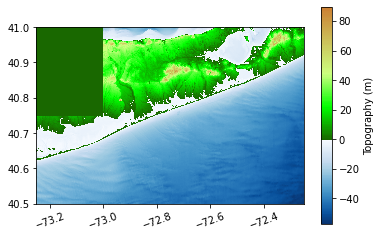

In [2]:
# topo = topotools.Topography()
topo = topotools.read_netcdf('/Users/catherinej/RData/Bathy/breach/moriches/moriches.nc')
topo.plot()

In [3]:

def grid_eval_2d(X, Y, Q, xout, yout, method='nearest', return_ma=True):
    """
    Utility function that takes a single patch of data in 2d and
    returns values on 1d or 2d grid specified by xout, yout.
    Input:
        arrays X,Y defining a grid patch and data Q on this patch,
            Q can be a 2d array of the same shape as X,Y or a
            3d array with Q[m,:,:] corresponding to the m'th value at each point
        xout, yout defining the points for output (1d or 2d arrays)
        method: by default 'nearest', which samples piecewise constant 
            values in each cell.  Can also set to 'linear'
        return_ma (bool) determines if output is a masked array
    Returns:
        qout
        
    ndim(Q) is either 2 or 3.  If 3, then Q[m,i,j] is  m'th variable at i,j
    if ndim(xout)==ndim(yout)==1 then an arbitrary set of points can be
        specified (e.g. along a transect, or curve, or scattered).
    if ndim(xout)==ndim(yout)==2 then Q is interpolated to this grid of points.
    
    if return_ma==True then the result is masked at points outside
        the limits of X,Y.   Otherwise result is NaN at these points.
    Uses zero-order interpolation, i.e.
        Sets value qout[i,j] to value in the finite volume grid cell
        of X,Y that contains (xout[i,j],yout[i,j]).
    Future: allow bilinear interpolation instead but this requires
        ghost cell values around Q grid.  (These are present in binary
        output fort.b files but normally thrown away.)
    """

    from scipy.interpolate import RegularGridInterpolator
    from numpy import ma  # for masked arrays
    
    Qdim = Q.ndim
    if Qdim == 2:
        # change to 3d array of shape (1, Q.shape[0], Q.shape[1]):
        Q = np.array([Q])
        
    nvars = Q.shape[0]  # number of arrays to interpolate

    ndim_out = len(xout.shape)
    xout1 = np.ravel(xout)
    yout1 = np.ravel(yout)
    x1 = X[:,0]
    y1 = Y[0,:]
    dx = x1[1] - x1[0]
    dy = y1[1] - y1[0]
    if dx<=0 or dy<=0:
        raise ValueError('X[:,0],Y[0,:] must be increasing. ' \
                + 'Need to transpose arrays?')

    # augment Q with border of values on all 4 sides:
    x1 = np.hstack((x1[0]-0.501*dx, x1, x1[-1]+0.501*dx))
    y1 = np.hstack((y1[0]-0.501*dy, y1, y1[-1]+0.501*dy))
    Q1 = np.empty((nvars,len(x1),len(y1)))
    Q1[:,1:-1, 1:-1] = Q   # center portion
    Q1[:,1:-1,0] = Q[:,:,0]
    Q1[:,1:-1,-1] = Q[:,:,-1]
    Q1[:,0,1:-1] = Q[:,0,:]
    Q1[:,-1,1:-1] = Q[:,-1,:]
    # corners:
    Q1[:,0,0] = Q[:,0,0]
    Q1[:,0,-1] = Q[:,0,-1]
    Q1[:,-1,-1] = Q[:,-1,-1]
    Q1[:,-1,0] = Q[:,-1,0]

    qout = np.empty([nvars]+list(xout.shape))
    for k in range(nvars):
        evalfunc = RegularGridInterpolator((x1,y1), Q1[k,:,:], method=method,
                bounds_error=False, fill_value=np.nan)
        xyout = np.vstack((xout1,yout1)).T
        qout_k = evalfunc(xyout)
        if ndim_out == 2:
            qout_k = np.reshape(qout_k, xout.shape)   
            qout[k,:,:] = qout_k
        else:
            qout[k,:] = qout_k

    if Qdim==2 and ndim_out==2:
        qout = qout[0,:,:]  # revert back to 2d array
    if Qdim==2 and ndim_out==1:
        qout = qout[0,:]  # revert back to 1d array

    if return_ma:
        # convert from an array with nan's to a masked array:
        qout = ma.masked_where(qout != qout, qout)

    #print('type is %s' % type(qout))

    return qout

In [4]:
xlon = -72.56
yout = np.linspace(40.815, 40.845, 1001)
xout = xlon * np.ones(yout.shape)
qout = grid_eval_2d(topo.X.T, topo.Y.T, topo.Z.T, xout, yout)

In [5]:
qout

masked_array(data=[-3.82197046, -3.74350643, -3.74350643, ...,
                    2.94085431,  2.94085431,  2.94085431],
             mask=False,
       fill_value=1e+20)

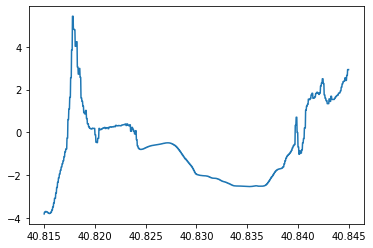

In [6]:
xlon = -72.56
# yout = np.linspace(40.815, 40.845, 1001)
# xout = xlon * np.ones(yout.shape)
yy = np.ma.masked_where((topo.X[:,0] >= xlon-0.01)*(topo.X[:,0] <= xlon +0.01), topo.Y[:,0])
y = topo.Y[:,0]
b = topo.Z[:,0]
plt.plot(yout, qout)
plt.show()

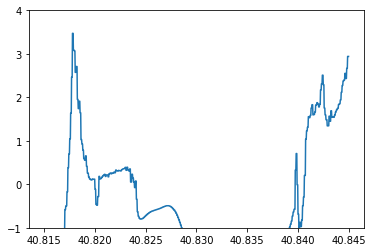

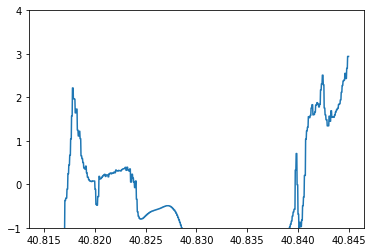

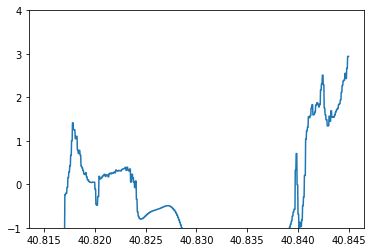

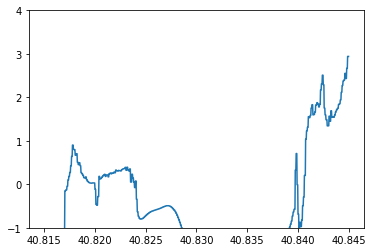

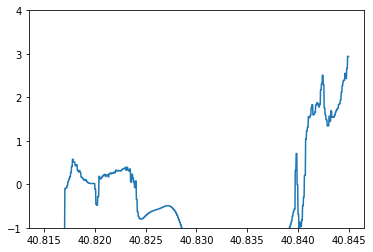

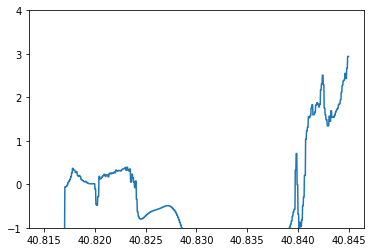

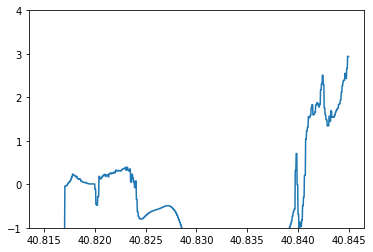

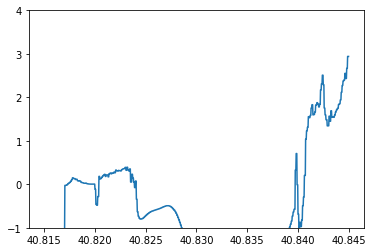

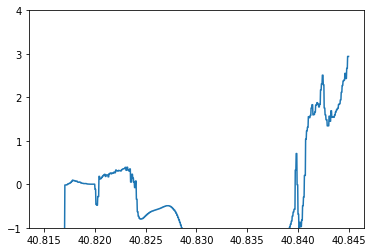

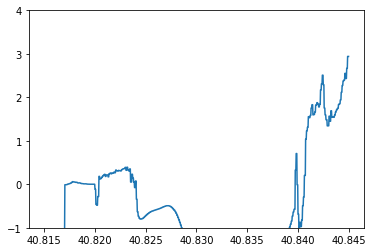

In [79]:
width = 3
height = [3,2,1,0]
breach = topo.Z.copy()
breach_loc = (-72.56, 40.815)
X = topo.X
Y = topo.Y
sigma=1
xlon = -72.56
yout = np.linspace(40.815, 40.845, 1001)
xout = xlon * np.ones(yout.shape)
qout = grid_eval_2d(topo.X.T, topo.Y.T, topo.Z.T, xout, yout)
# plt.show()
for i in range(10):
    for xidx, j in enumerate(topo.x):
        for yidx, k in enumerate(topo.y):
            if (j <= -72.555) and (j >= -72.565):
                if (k >= 40.81) and (k <= 40.82):
                    if (breach[yidx, xidx] >= -1.0):
                        initial = breach[yidx, xidx]
                        for depth in range(10,-1, -1):
    #                         print(breach[yidx, xidx])
                    # print('found something')
                    # print(j)
    #                     b = (j+90.5)**2 + i
    #                     print(b)
#                             breach[yidx, xidx] = breach[yidx, xidx] - ((j - breach_loc[0])**2 + depth) *(0.04 * breach[yidx, xidx])
                            breach[yidx, xidx] = breach[yidx,xidx] - (sigma * np.exp(-0.5 *(j-breach_loc[0])**2)/sigma**2) * (0.04*breach[yidx, xidx])
                            final = breach[yidx, xidx]
    #                         print(initial, final)
    #                     print(breach[yidx, xidx])
    #     # breach = breach -

    bout = grid_eval_2d(topo.X.T, topo.Y.T, breach.T, xout, yout)
    plt.plot(yout, bout) # norm=colors.Normalize(vmin=0, vmax=2),shading='auto'
    plt.ylim(-1, 4)
                    # plt.xlim(40.805, 40.845)
                    # plt.xlim(-72.565, -72.555)
                    #     plt.savefig(f'/mnt/c/Projects/plots/{i}.png')
    plt.show()
#  aux(1, i, j) = aux(1,i,j) - (sigma * exp(-0.5 * (x - mu)**2/sigma**2)) * &
#                                     (time_ratio * aux(1,i,j))
# ridge = 3
# for k in range(5):
#     print(ridge)
#     ridge = ridge - ((.005)**2 + k) * (.002 * ridge)

In [43]:
breach[yidx, xidx]

0.0